# Poisson problem example

Based on code by Eldar Khattatov

https://bitbucket.org/eldarkh/geo384_f2018/src/master/Material/1_Poisson1D/Poisson1D.py

https://bitbucket.org/eldarkh/geo384_f2018/src/master/Material/2_ConvergenceRates/ConvergenceRates.py

### Problem:
Solve Dirichlet BVP
$$\begin{cases}
-\frac{d^2u}{dx^2} = f(x) &\quad \text{in } (0,1) \\
u(0) = u(1) = 0
\end{cases}$$
with $f(x) = \sin(3\pi x)$.

In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt

Number of degrees of freedom= 21


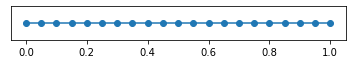

In [2]:
n = 20
mesh = UnitIntervalMesh(n)
V = FunctionSpace(mesh, 'CG', 1)

plot(mesh)
print('Number of degrees of freedom=', V.dim())

Text(0.5, 1.0, 'right hand side source f')

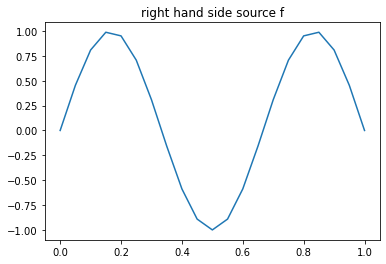

In [3]:
f = Expression('sin(a * pi * x[0])', a=3, degree=5, domain=mesh)

plot(f, mesh=mesh)
plt.title('right hand side source f')

In [4]:
u_bc = Constant(0.0)

def dirichlet_boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_bc, dirichlet_boundary)

### Weak form

The weak for for this problem is to find $u$ such that
$$\int_0^1 \frac{d u}{ dx}\frac{d v}{ dx} dx = \int_0^1 f v dx$$
for all $v$.

In [5]:
u_trial = TrialFunction(V)
v_test = TestFunction(V)

stiffness_form = inner(grad(u_trial), grad(v_test)) * dx
right_hand_side_form = f * v_test * dx

### Assemble stiffness matrix and right hand side vector. Apply boundary conditions

In [6]:
A = assemble(stiffness_form)
b = assemble(right_hand_side_form)

bc.apply(A)
bc.apply(b)

### Solve the linear system $Au=b$

Text(0.5, 1.0, 'computed solution u')

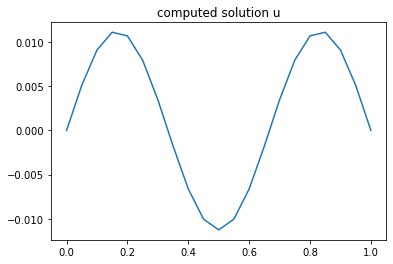

In [7]:
u = Function(V)
solve(A, u.vector(), b)

plot(u)
plt.title('computed solution u')

### Compare to exact solution
The exact solution for this problem is
$$u_\text{exact}(x) = \frac{1}{(3\pi)^2} \sin(3 \pi x)$$

Text(0.5, 1.0, 'exact solution u')

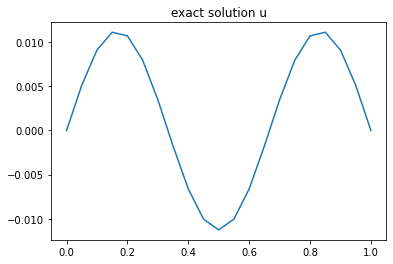

In [8]:
u_exact = Expression('(1. / pow(3*pi,2)) * sin(3*pi*x[0])', degree=5, domain=mesh)

plot(u_exact, mesh=mesh)
plt.title('exact solution u')

### Compute $L^2$ error

$$\|u - u_\text{exact}\|^2_{L^2} = \int_0^1 (u - u_\text{exact})^2 dx$$

In [9]:
err_L2_squared_form = (u - u_exact)**2 * dx
err_L2_squared = assemble(err_L2_squared_form)
err_L2 = np.sqrt(err_L2_squared)

print('err_L2=', err_L2)

err_L2= 0.00016059371634571378


### Compute $H^1$ error

$$\|u - u_\text{exact}\|^2_{H^1} = \int_0^1 \left(\frac{du}{dx} - \frac{du_\text{exact}}{dx}\right)^2 dx$$

In [10]:
misfit_form = grad(u) - grad(u_exact)
err_H1 = np.sqrt(assemble(inner(misfit_form, misfit_form) * dx))

print('err_H1=', err_H1)

err_H1= 0.010168511134290445


## Make convergence plot for $P^1$ Lagrange elements

In [11]:
nn = [2,4,8,16,32,64]
P1_errs_L2 = []
P1_errs_H1 = []
for n in nn:
    mesh = UnitIntervalMesh(n)
    V = FunctionSpace(mesh, 'CG', 1)

    f = Expression('sin(a * pi * x[0])', a=3, degree=5, domain=mesh)
    
    u_bc = Constant(0.0)

    def dirichlet_boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_bc, dirichlet_boundary)
    
    u_trial = TrialFunction(V)
    v_test = TestFunction(V)

    stiffness_form = inner(grad(u_trial), grad(v_test)) * dx
    right_hand_side_form = f * v_test * dx
    
    A = assemble(stiffness_form)
    b = assemble(right_hand_side_form)

    bc.apply(A)
    bc.apply(b)
    
    u = Function(V)
    solve(A, u.vector(), b)
    
    u_exact = Expression('(1. / pow(3*pi,2)) * sin(3*pi*x[0])', degree=5, domain=mesh)
    
    err_L2 = np.sqrt(assemble((u - u_exact)**2 * dx))
    P1_errs_L2.append(err_L2)
    
    misfit_form = grad(u) - grad(u_exact)
    err_H1 = np.sqrt(assemble(inner(misfit_form, misfit_form) * dx))
    P1_errs_H1.append(err_H1)
    
    print('n=', n, ', err_L2=', err_L2, ', err_H1=', err_H1)

n= 2 , err_L2= 0.009755925508080984 , err_H1= 0.07164432164081075
n= 4 , err_L2= 0.0035688381657015575 , err_H1= 0.04654970010950354
n= 8 , err_L2= 0.0009784107627888324 , err_H1= 0.024932896701448055
n= 16 , err_L2= 0.00025024372690999317 , err_H1= 0.01268421953007199
n= 32 , err_L2= 6.291758665764009e-05 , err_H1= 0.006369664768540052
n= 64 , err_L2= 1.575175204485747e-05 , err_H1= 0.0031882872246637006


Text(0, 0.5, 'error')

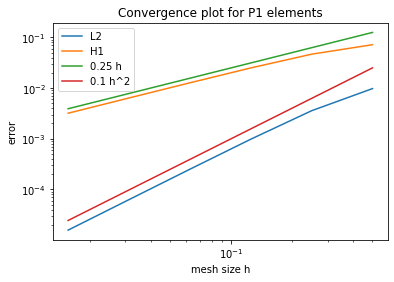

In [12]:
hh = 1./np.array(nn)
plt.loglog(hh, P1_errs_L2)
plt.loglog(hh, P1_errs_H1)
plt.loglog(hh, 0.25*hh)
plt.loglog(hh,0.1*hh**2)
plt.legend(['L2', 'H1', '0.25 h', '0.1 h^2'])
plt.title('Convergence plot for P1 elements')
plt.xlabel('mesh size h')
plt.ylabel('error')

## Make convergence plot for $P^2$ Lagrange elements

In [13]:
nn = [2,4,8,16,32,64]
P2_errs_L2 = []
P2_errs_H1 = []
for n in nn:
    mesh = UnitIntervalMesh(n)
    V = FunctionSpace(mesh, 'CG', 2) # <---- P2 elements instead of P1

    f = Expression('sin(a * pi * x[0])', a=3, degree=5, domain=mesh)
    
    u_bc = Constant(0.0)

    def dirichlet_boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_bc, dirichlet_boundary)
    
    u_trial = TrialFunction(V)
    v_test = TestFunction(V)

    stiffness_form = inner(grad(u_trial), grad(v_test)) * dx
    right_hand_side_form = f * v_test * dx
    
    A = assemble(stiffness_form)
    b = assemble(right_hand_side_form)

    bc.apply(A)
    bc.apply(b)
    
    u = Function(V)
    solve(A, u.vector(), b)
    
    u_exact = Expression('(1. / pow(3*pi,2)) * sin(3*pi*x[0])', degree=5, domain=mesh)
    
    err_L2 = np.sqrt(assemble((u - u_exact)**2 * dx))
    P2_errs_L2.append(err_L2)
    
    misfit_form = grad(u) - grad(u_exact)
    err_H1 = np.sqrt(assemble(inner(misfit_form, misfit_form) * dx))
    P2_errs_H1.append(err_H1)
    
    print('n=', n, ', err_L2=', err_L2, ', err_H1=', err_H1)

n= 2 , err_L2= 0.0033749814672891596 , err_H1= 0.045417133569080795
n= 4 , err_L2= 0.0005508471885095861 , err_H1= 0.014341580964990693
n= 8 , err_L2= 7.330792220946234e-05 , err_H1= 0.0038045449872422276
n= 16 , err_L2= 9.307751484146686e-06 , err_H1= 0.0009653780338495042
n= 32 , err_L2= 1.1680197926654648e-06 , err_H1= 0.00024224329054418965
n= 64 , err_L2= 1.4614502672994468e-07 , err_H1= 6.061713260647829e-05


Text(0, 0.5, 'error')

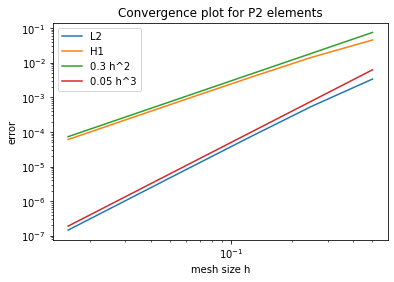

In [14]:
hh = 1./np.array(nn)
plt.loglog(hh, P2_errs_L2)
plt.loglog(hh, P2_errs_H1)
plt.loglog(hh, 0.3*hh**2)
plt.loglog(hh,0.05*hh**3)
plt.legend(['L2', 'H1', '0.3 h^2', '0.05 h^3'])
plt.title('Convergence plot for P2 elements')
plt.xlabel('mesh size h')
plt.ylabel('error')

# Extra content: spatially varying coefficient

Solve Dirichlet BVP
$$\begin{cases}
-\frac{d}{dx} k \frac{du}{dx} = f(x) &\quad \text{in } (0,1) \\
u(0) = u(1) = 0
\end{cases}$$
with $f(x) = \sin(3\pi x)$ and $k(x) = 1 + x^2$.

### Weak form:
$$\int_0^1 k\frac{d u}{ dx}\frac{d v}{ dx} dx = \int_0^1 f v dx$$
for all $v$.

Text(0.5, 1.0, 'inhomogeneous solution u')

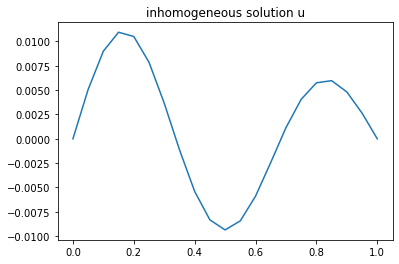

In [15]:
n = 20
mesh = UnitIntervalMesh(n)
V = FunctionSpace(mesh, 'CG', 1)

f = Expression('sin(a * pi * x[0])', a=3, degree=5, domain=mesh)
k = Expression('1 + pow(x[0],2)', degree=5, domain=mesh)

u_bc = Constant(0.0)

def dirichlet_boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_bc, dirichlet_boundary)

u_trial = TrialFunction(V)
v_test = TestFunction(V)

stiffness_form = inner(k * grad(u_trial), grad(v_test)) * dx # <--- notice k here
right_hand_side_form = f * v_test * dx

A = assemble(stiffness_form)
b = assemble(right_hand_side_form)

bc.apply(A)
bc.apply(b)

u = Function(V)
solve(A, u.vector(), b)

plot(u)
plt.title('inhomogeneous solution u')